<a href="https://colab.research.google.com/github/filippozuddas/ML-SRT-SETI/blob/main/notebooks/train_CVAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install setigen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.3/104.3 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 47.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.3/249.3 kB 72.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 MB 32.8 MB/s eta 0:00:00
  Attempting uninstall: pyparsing
    Found existing installation: pyparsing 3.2.3
    Uninstalling pyparsing-3.2.3:
      Successfully uninstalled pyparsing-3.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pydot 3.0.4 requires pyparsing>=3.0.9, but you have pyparsing 2.4.7 which is incompatible.


In [1]:
import sys
import os

# --- CONFIGURAZIONE PERCORSI ---
PROJECT_ROOT = "/content/filippo/ML-SRT-SETI"
PROJECT_ROOT_LOCAL = "/home/filippo/TirocinioSETI/ML-SRT-SETI"

if not os.path.exists(PROJECT_ROOT_LOCAL):
    raise FileNotFoundError(f"{PROJECT_ROOT_LOCAL} folder not found")

os.chdir(PROJECT_ROOT_LOCAL)

if PROJECT_ROOT_LOCAL not in sys.path:
    sys.path.append(PROJECT_ROOT_LOCAL)

print(f"✅ Setup completed!")
print(f"   Working directory: {os.getcwd()}")

✅ Setup completed!
   Working directory: /home/filippo/TirocinioSETI/ML-SRT-SETI


In [3]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from src import config, models, paper_model
from src.models import VAE
from src.paper_model import build_model

# Verifica GPU
print(f"TensorFlow Version: {tf.__version__}")
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow Version: 2.10.1
Num GPUs Available:  0


In [4]:
DATASET_PATH = "data/synthetic_dataset.npz"
MODELS_FOLDER = "models"
MODELS_WEIGHTS_PATH = "models/weights/beta_vae_weights.h5"

os.makedirs(MODELS_FOLDER, exist_ok=True)

INPUT_SHAPE = (16, 512, 1)
LATENT_DIM = 8
ALPHA = 10.0
BETA = 1.5
BATCH_SIZE = 32
LR = 0.001
EPOCHS = 50

In [5]:
def create_tf_dataset(recon_data, true_data, false_data, batch_size):
    """
    Crea un tf.data.Dataset ottimizzato a partire dai tensori numpy
    """
    # Creazione del dataset da slice di tensori
    # Input X: (Reconstruction, True Cadence, False Cadence)
    # Target Y: Reconstruction
    ds = tf.data.Dataset.from_tensor_slices(
        ((recon_data, true_data, false_data), recon_data)
    )
    
    # Shuffle, Batching e Prefetching
    # drop_remainder=True è importante per training multi-GPU (MirroredStrategy)
    ds = ds.shuffle(2048).batch(batch_size, drop_remainder=True)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    
    return ds

def load_data(filepath, split=0.8):
    """
    Carica i dati dal file .npz, esegue lo split e restituisce i dataset TF pronti.
    """
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File {filepath} non trovato!")
        
    print(f"Loading data from {filepath}...")
    with np.load(filepath) as f:
        mixed = f['mixed_cadence']
        true_c = f['true_cadence']
        false_c = f['false_cadence']
        
    print(f"Total samples: {len(mixed)}")
    
    # Prepariamo l'input per la ricostruzione (Solo il primo frame ON della sequenza)
    # Assumiamo che mixed sia (N, 6, 16, 512, 1) -> x_recon diventa (N, 16, 512, 1)
    x_recon = mixed[:, 0, :, :, :] 
    
    # Creazione degli indici per lo split
    indices = np.arange(len(mixed))
    train_idx, val_idx = train_test_split(indices, train_size=split, random_state=42)
        
    # Creazione Train Dataset
    # Passiamo direttamente le slice degli array usando gli indici di train
    train_ds = create_tf_dataset(
        recon_data=x_recon[train_idx],
        true_data=true_c[train_idx],
        false_data=false_c[train_idx],
        batch_size=BATCH_SIZE
    )
    
    # Creazione Validation Dataset
    # Passiamo direttamente le slice degli array usando gli indici di val
    val_ds = create_tf_dataset(
        recon_data=x_recon[val_idx],
        true_data=true_c[val_idx],
        false_data=false_c[val_idx],
        batch_size=BATCH_SIZE
    )
    
    return train_ds, val_ds

In [6]:
train_dataset, val_dataset = load_data(DATASET_PATH)

Loading data from data/synthetic_dataset.npz...
Total samples: 128


# Paper model test

In [7]:
alpha, beta, gamma = 10,1.5,0
latent_dim=8
dens_lay=512
kernel=(3,3)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = build_model(latent_dim,dens_lay, kernel, alpha, beta, gamma)

tensorflow      WARNING  There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 16, 512, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 8, 256, 16)   160         ['input_1[0][0]']                
                                                                      

/home/filippo/miniconda3/envs/ml_gbt_seti/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [21]:
def plot_model(history):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2,figsize=(15,10))


    ax1.plot(history.history['false_loss'])
    ax1.plot(history.history['true_loss'])
    """ax1.plot(history.history['val_false_loss'])
    ax1.plot(history.history['val_true_loss'])"""
    ax1.set_title('Model Clustering Loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['false_loss', 'true_loss','val_false_loss','val_true_loss'], loc='upper right')
    ax1.grid()

    ax2.plot(history.history['false_score'])
    ax2.plot(history.history['true_score'])
    """ax2.plot(history.history['val_false_score'])
    ax2.plot(history.history['val_true_score'])"""
    ax2.set_title('Model Clustering Score')
    ax2.set_ylabel('loss')
    ax2.set_xlabel('epoch')
    ax2.legend(['false_score', 'true_score','val_false_score','val_true_score'], loc='upper right')
    ax2.grid()

    ax3.plot(history.history['reconstruction_loss'])
    #ax3.plot(history.history['val_reconstruction_loss'])
    ax3.set_title('Model Reconstruction')
    ax3.set_ylabel('loss')
    ax3.set_xlabel('epoch')
    ax3.legend(['reconstruction_loss', 'val_reconstruction_loss'], loc='upper right')
    ax3.grid()

    ax4.plot(history.history['kl_loss'])
    #ax4.plot(history.history['val_kl_loss'])
    ax4.set_title('Model Divergence')
    ax4.set_ylabel('loss')
    ax4.set_xlabel('epoch')
    ax4.legend(['kl_loss', 'val_kl_loss'], loc='upper right')
    ax4.grid()
    
    plt.show()

In [ ]:
history = model.fit(
	train_dataset,
	epochs=EPOCHS,
	validation_data=val_dataset
)

2025-11-25 15:08:12.518630: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_DOUBLE
      type: DT_DOUBLE
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 102
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:0"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 16
        }
        dim {
          size: 512
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 6
       

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 4824.4871 - reconstruction_loss: 4678.7549 - kl_loss: 18.9240 - false_loss: 11.3243 - true_loss: 14.9923 - false_score: 0.0000e+00 - true_score: 0.0000e+00

2025-11-25 15:08:16.388889: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_DOUBLE
      type: DT_DOUBLE
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 26
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\024TensorSliceDataset:4"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 16
        }
        dim {
          size: 512
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 6
        

3/3 [==============================] - 4s 1s/step - loss: 4826.3245 - reconstruction_loss: 4678.7549 - kl_loss: 18.9240 - false_loss: 11.3102 - true_loss: 14.9836 - false_score: 0.0000e+00 - true_score: 0.0000e+00
Epoch 2/50
3/3 [==============================] - 4s 1s/step - loss: 4766.9735 - reconstruction_loss: 4696.1953 - kl_loss: 18.1663 - false_loss: 11.1607 - true_loss: 14.8552 - false_score: 0.0000e+00 - true_score: 0.0000e+00
Epoch 3/50
3/3 [==============================] - 3s 1s/step - loss: 4793.6908 - reconstruction_loss: 4665.4600 - kl_loss: 18.6639 - false_loss: 11.0144 - true_loss: 14.7356 - false_score: 0.0000e+00 - true_score: 0.0000e+00
Epoch 4/50
2/3 [===================>..........] - ETA: 1s - loss: 4805.6301 - reconstruction_loss: 4642.4429 - kl_loss: 19.1642 - false_loss: 10.9012 - true_loss: 14.6530 - false_score: 0.0000e+00 - true_score: 0.0000e+00

KeyboardInterrupt: 

: 

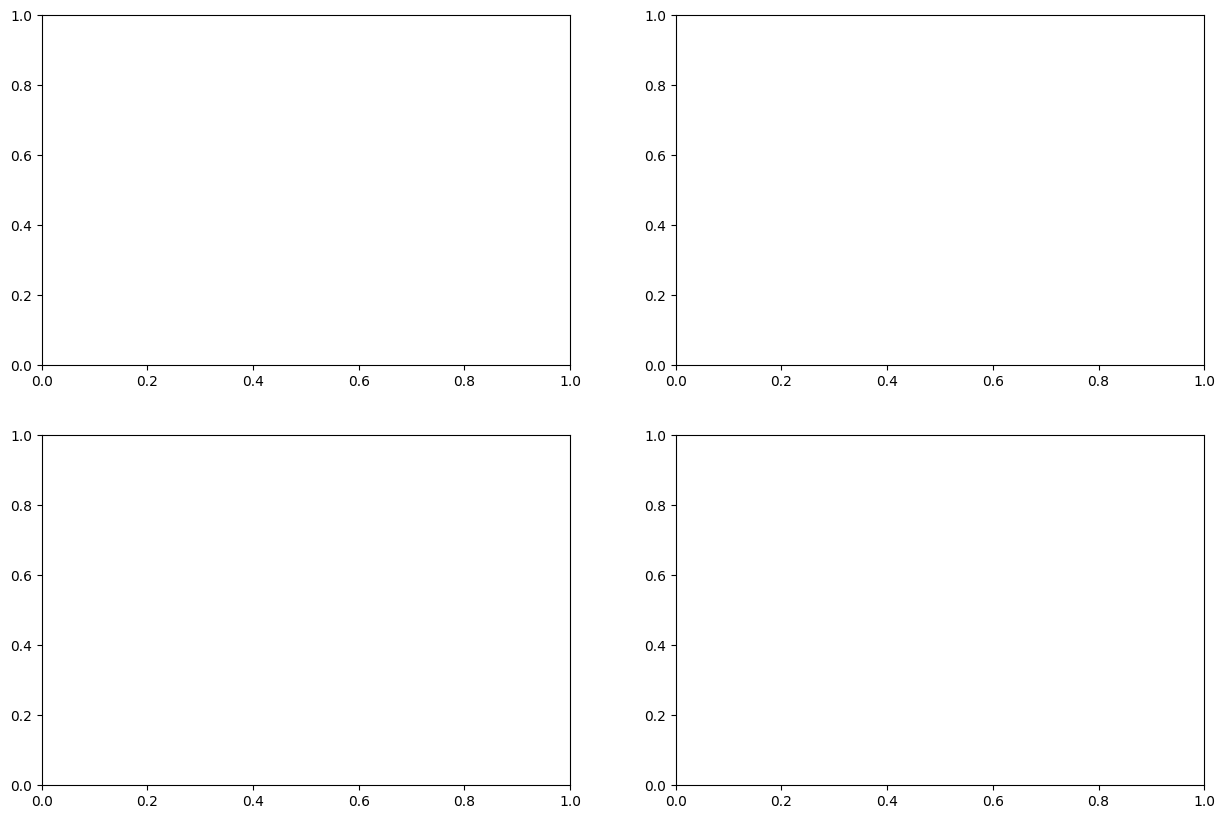

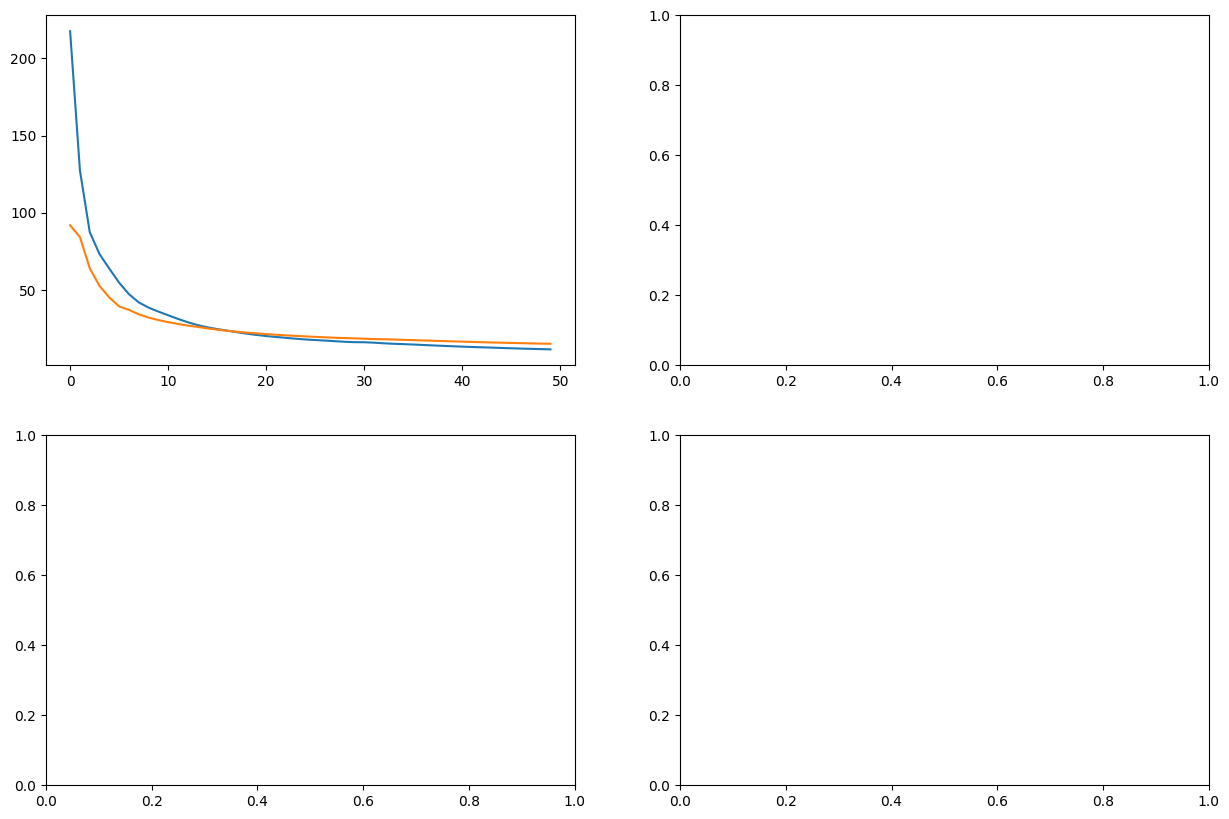

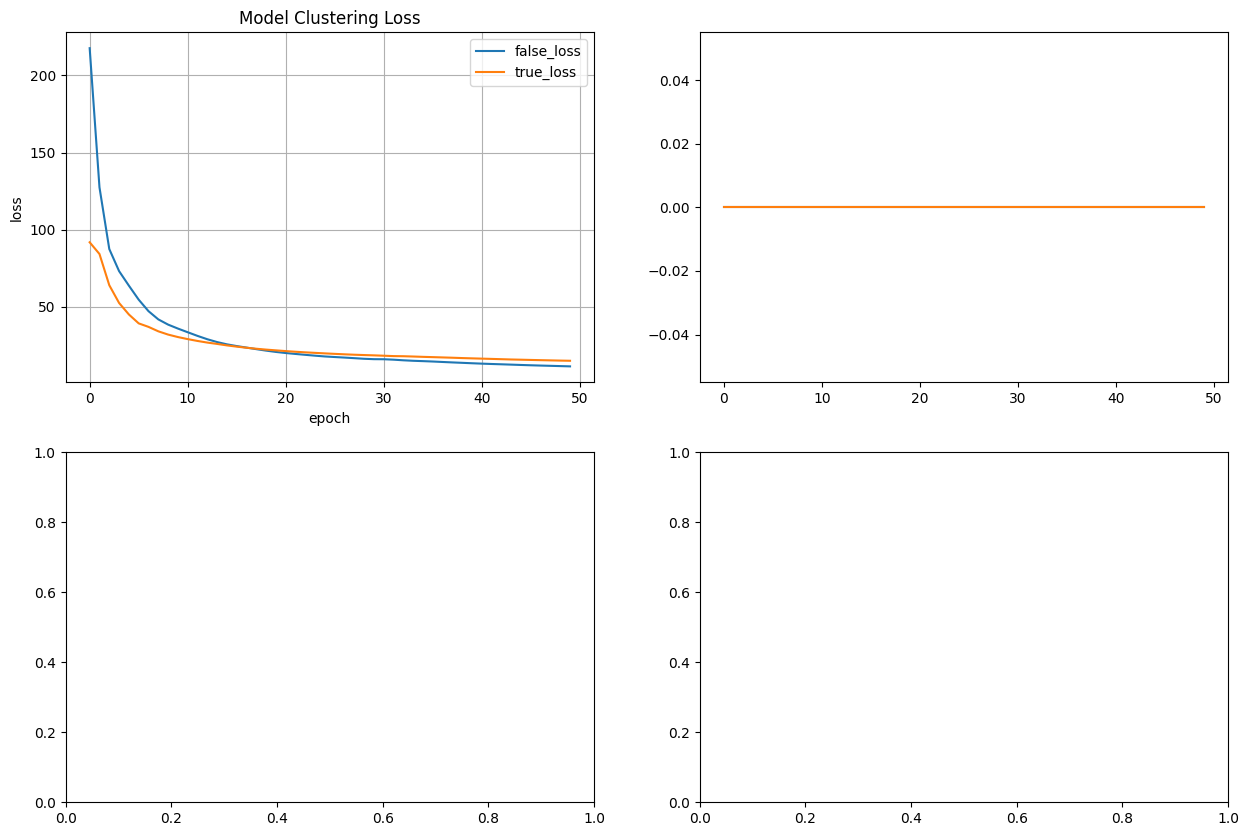

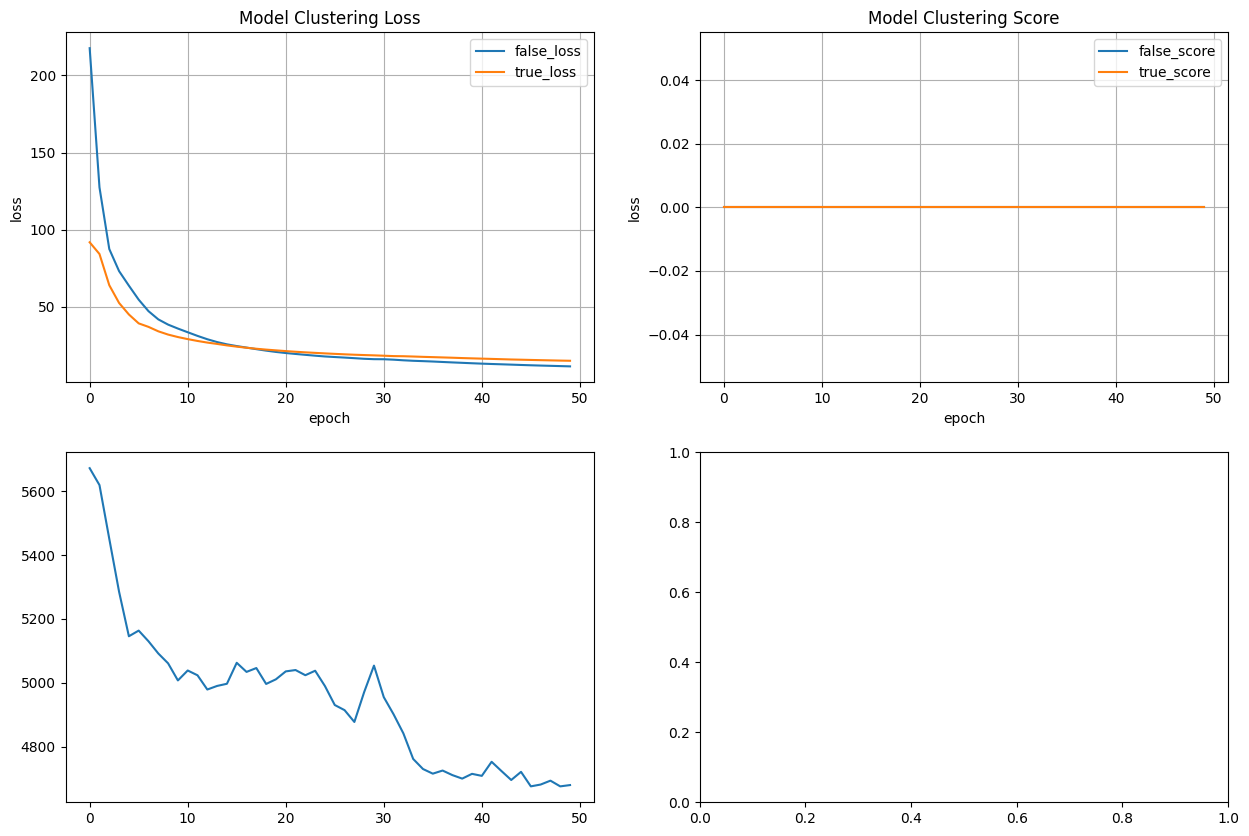

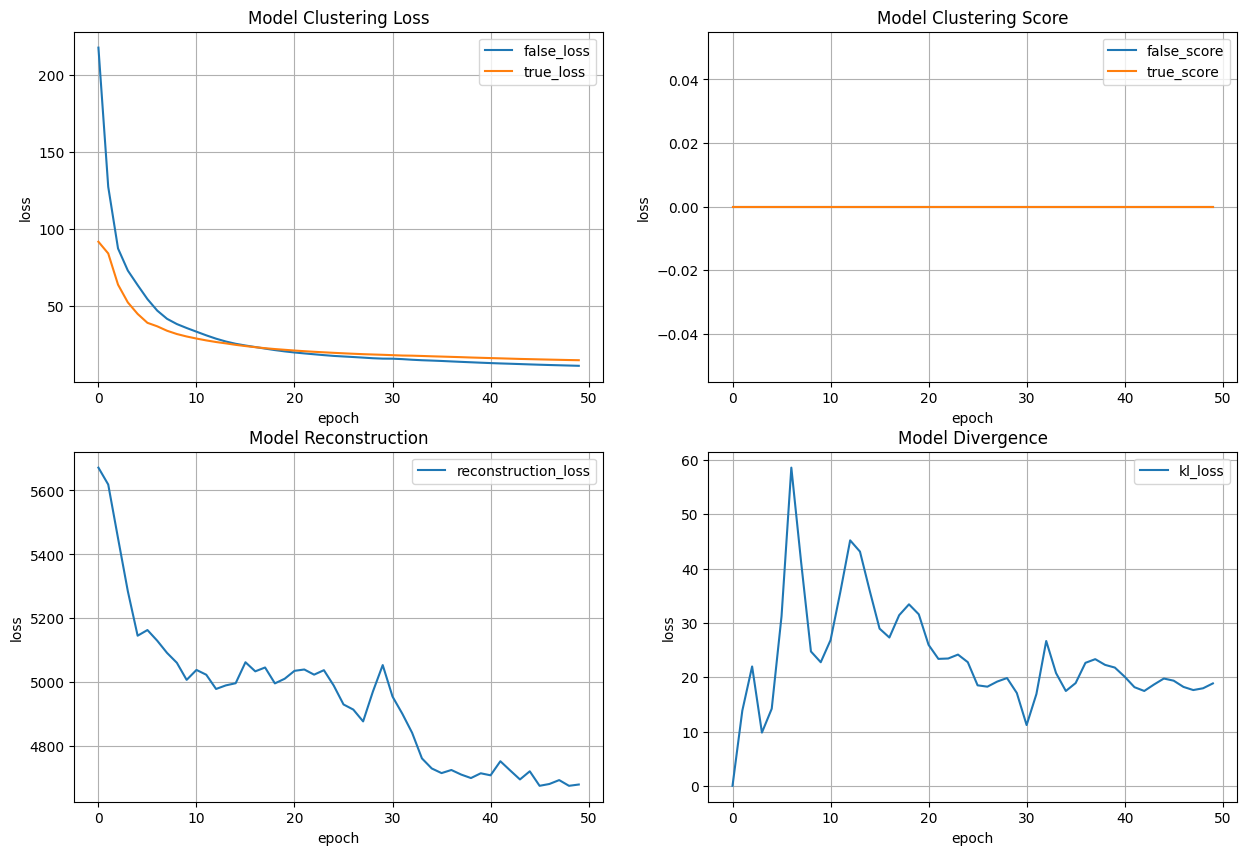

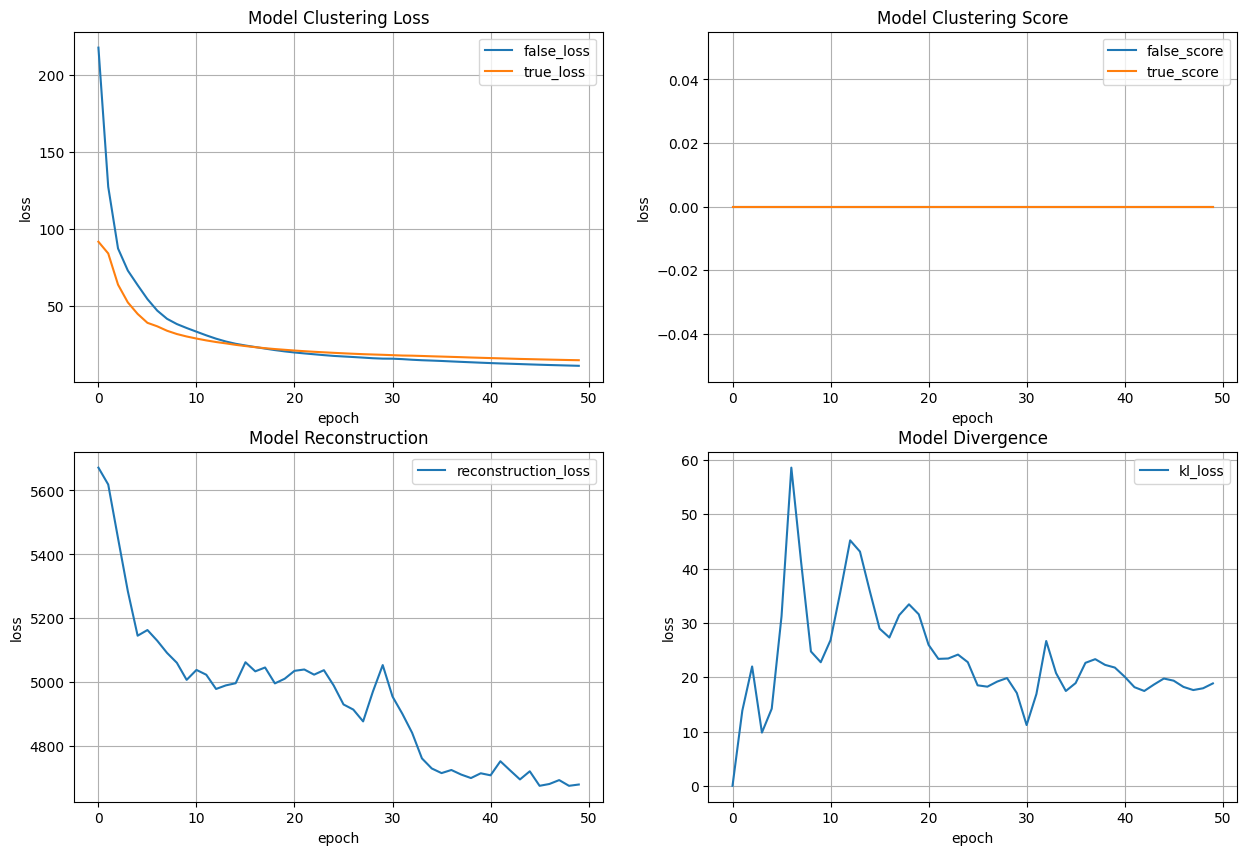

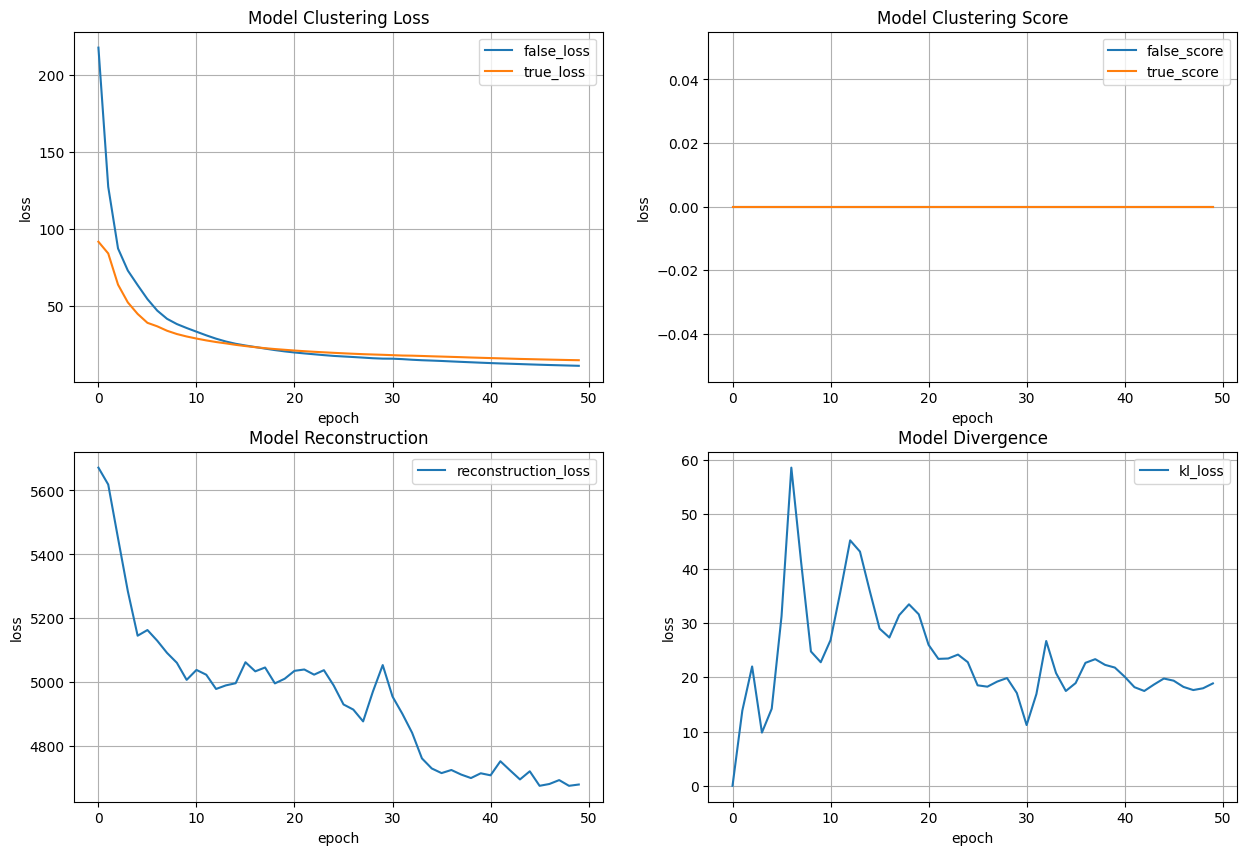

In [23]:

%matplotlib inline
plot_model(history)

# My model 

In [35]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope(): 
    encoder = models.build_encoder(latent_dim=LATENT_DIM)
    decoder = models.build_decoder(latent_dim=LATENT_DIM)
    vae = VAE(encoder, decoder, alpha=ALPHA, beta=BETA)

    # Compilazione con ottimizzatore standard
    vae.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
    

tensorflow      WARNING  There are non-GPU devices in `tf.distribute.Strategy`, not using nccl allreduce.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
tensorflow      INFO     Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


In [38]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", 
        patience=10, 
        restore_best_weights=True,
        verbose=1
    ),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=5,
        verbose=1
    ),
]

In [ ]:
print("Starting training...")

history = vae.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS,
    callbacks=callbacks
)

Starting training...


2025-11-24 16:22:07.217130: W tensorflow/core/grappler/optimizers/data/auto_shard.cc:776] AUTO sharding policy will apply DATA sharding policy as it failed to apply FILE sharding policy because of the following reason: Found an unshardable source dataset: name: "TensorSliceDataset/_4"
op: "TensorSliceDataset"
input: "Placeholder/_0"
input: "Placeholder/_1"
input: "Placeholder/_2"
input: "Placeholder/_3"
attr {
  key: "Toutput_types"
  value {
    list {
      type: DT_DOUBLE
      type: DT_DOUBLE
      type: DT_DOUBLE
      type: DT_DOUBLE
    }
  }
}
attr {
  key: "_cardinality"
  value {
    i: 102
  }
}
attr {
  key: "is_files"
  value {
    b: false
  }
}
attr {
  key: "metadata"
  value {
    s: "\n\025TensorSliceDataset:46"
  }
}
attr {
  key: "output_shapes"
  value {
    list {
      shape {
        dim {
          size: 16
        }
        dim {
          size: 512
        }
        dim {
          size: 1
        }
      }
      shape {
        dim {
          size: 6
      

Epoch 1/50
3/3 [==============================] - ETA: 0s - loss: 5251.2212 - reconstruction_loss: 5084.5280 - kl_loss: 33.4345 - true_loss: 8.8983 - false_loss: 2.5734WARNING:tensorflow:Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,reconstruction_loss,kl_loss,true_loss,false_loss
tensorflow      WARNING  Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,reconstruction_loss,kl_loss,true_loss,false_loss
tensorflow      WARNING  Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,reconstruction_loss,kl_loss,true_loss,false_loss,lr
3/3 [==============================] - 4s 1s/step - loss: 5251.4133 - reconstruction_loss: 5085.1763 - kl_loss: 33.4345 - true_loss: 8.8983 - false_loss: 2.5734 - lr: 0.0010
Epoch 2/50
3/3 [==============================] - ETA: 0s - loss: 5247.2695 - reconstruction_loss: 5090.3156 - kl_loss: 39.1998

KeyboardInterrupt: 

: 